In [1]:
# Install dependencies
!pip install cryptography requests pandas matplotlib

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import base64
import time
from datetime import datetime
from getpass import getpass

import requests
import pandas as pd
import matplotlib.pyplot as plt

from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
from cryptography.hazmat.primitives.asymmetric import ed25519
from cryptography.fernet import Fernet


In [3]:
# Define Drive storage paths
drive_folder = '/content/drive/MyDrive/secure_btc'
os.makedirs(drive_folder, exist_ok=True)

salt_path = os.path.join(drive_folder, 'salt.bin')
data_file = os.path.join(drive_folder, 'data_store.jsonl')
priv_path = os.path.join(drive_folder, 'ed_priv.key')
pub_path  = os.path.join(drive_folder, 'ed_pub.key')

# Derive Fernet key using PBKDF2-HMAC with salt
if os.path.exists(salt_path):
    salt = open(salt_path, 'rb').read()
else:
    salt = os.urandom(16)
    open(salt_path, 'wb').write(salt)

password = getpass("Enter a strong password: ").encode()
kdf = PBKDF2HMAC(
    algorithm=hashes.SHA256(),
    length=32,
    salt=salt,
    iterations=390000,
)
key = base64.urlsafe_b64encode(kdf.derive(password))
fernet = Fernet(key)


Enter a strong password: ··········


In [4]:
# Generate or load Ed25519 key pair for signing
if os.path.exists(priv_path) and os.path.exists(pub_path):
    with open(priv_path, 'rb') as f:
        priv_bytes = f.read()
    with open(pub_path, 'rb') as f:
        pub_bytes = f.read()
    ed_priv = ed25519.Ed25519PrivateKey.from_private_bytes(priv_bytes)
    ed_pub  = ed25519.Ed25519PublicKey.from_public_bytes(pub_bytes)
else:
    ed_priv = ed25519.Ed25519PrivateKey.generate()
    ed_pub  = ed_priv.public_key()
    open(priv_path, 'wb').write(
        ed_priv.private_bytes(
            encoding=serialization.Encoding.Raw,
            format=serialization.PrivateFormat.Raw,
            encryption_algorithm=serialization.NoEncryption()
        )
    )
    open(pub_path, 'wb').write(
        ed_pub.public_bytes(
            encoding=serialization.Encoding.Raw,
            format=serialization.PublicFormat.Raw
        )
    )

In [5]:
def fetch_price():
    """Fetch current BTC price (USD) from CoinGecko."""
    url = "https://api.coingecko.com/api/v3/simple/price"
    resp = requests.get(url, params={"ids": "bitcoin", "vs_currencies": "usd"})
    return resp.json()["bitcoin"]["usd"]

def encrypt_and_sign(payload: bytes):
    """Encrypt with Fernet and then sign with Ed25519."""
    token = fernet.encrypt(payload)
    signature = ed_priv.sign(token)
    return token, signature

def verify_and_decrypt(token: bytes, sig: bytes):
    """Verify Ed25519 signature, then decrypt Fernet token."""
    ed_pub.verify(sig, token)
    return fernet.decrypt(token)

In [6]:
# Ingest & append data points
for i in range(10):
    ts = datetime.utcnow().isoformat()
    price = fetch_price()
    payload = json.dumps({"ts": ts, "price": price}).encode()

    token, signature = encrypt_and_sign(payload)
    record = {
        "ts": ts,
        "enc": token.decode(),
        "sig": base64.b64encode(signature).decode()
    }
    with open(data_file, 'a') as f:
        f.write(json.dumps(record) + "\n")

    print(f"[{i+1}/10] {ts} → ${price:.2f}")
    time.sleep(60)  # wait 1 minute


[1/10] 2025-04-23T03:51:19.206835 → $93046.00
[2/10] 2025-04-23T03:52:19.613361 → $93064.00
[3/10] 2025-04-23T03:53:19.689823 → $93073.00
[4/10] 2025-04-23T03:54:19.789204 → $93077.00
[5/10] 2025-04-23T03:55:19.868776 → $93094.00
[6/10] 2025-04-23T03:56:19.972992 → $93098.00
[7/10] 2025-04-23T03:57:20.093343 → $93106.00
[8/10] 2025-04-23T03:58:20.212126 → $93129.00
[9/10] 2025-04-23T03:59:20.302542 → $93134.00
[10/10] 2025-04-23T04:00:20.431373 → $93143.00


In [46]:
# Load, verify, decrypt and build DataFrame
records = []
with open(data_file, 'r') as f:
    for line in f:
        rec = json.loads(line)
        try:
            token = rec["enc"].encode()
            sig   = base64.b64decode(rec["sig"])
            plaintext = verify_and_decrypt(token, sig)
            obj = json.loads(plaintext.decode())
            records.append(obj)
        except Exception as e:
            print(f"Failed at {rec['ts']}: {e}")

df = pd.DataFrame(records)
df["ts"] = pd.to_datetime(df["ts"])
df = df.sort_values("ts").reset_index(drop=True)

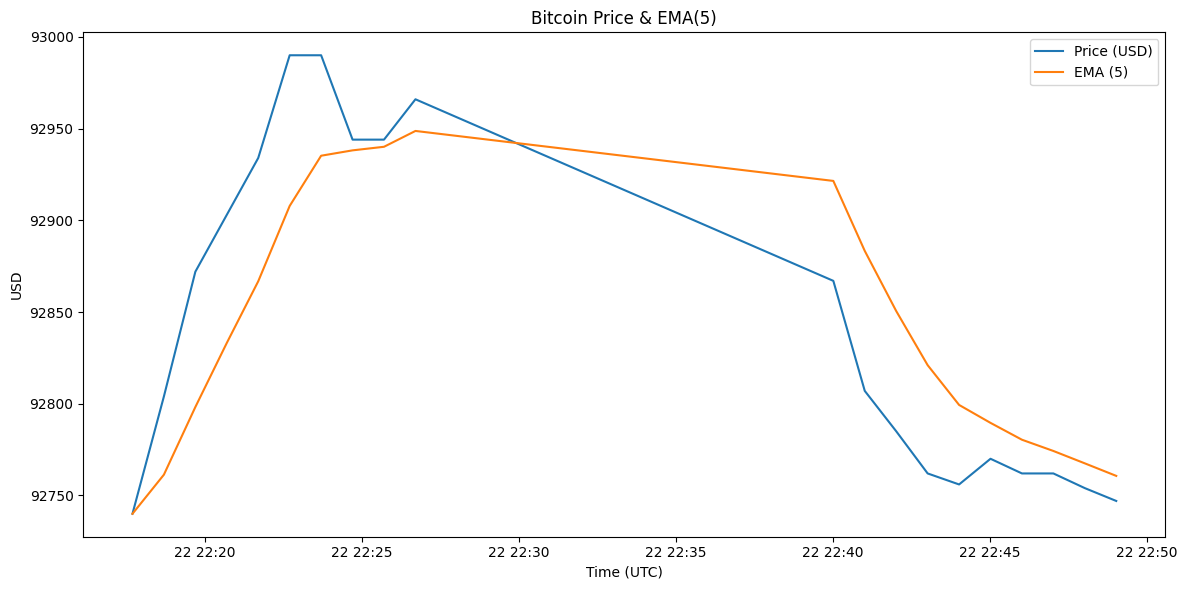

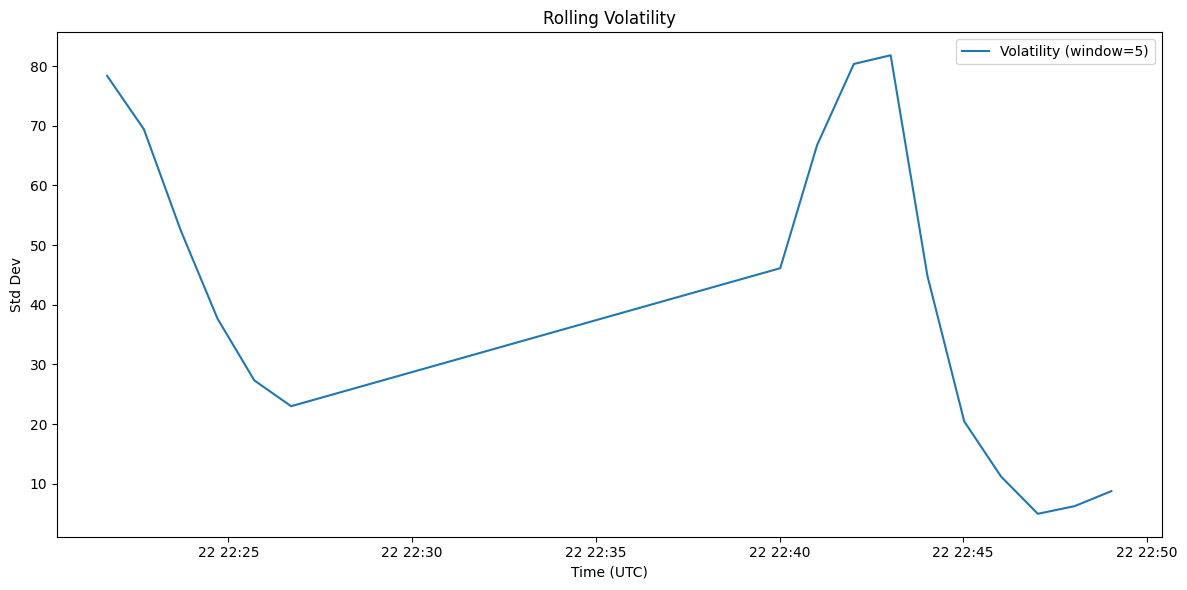

In [47]:
df["ema_5"] = df["price"].ewm(span=5, adjust=False).mean()
df["volatility"] = df["price"].rolling(window=5).std()

plt.figure()
plt.plot(df["ts"], df["price"], label="Price (USD)")
plt.plot(df["ts"], df["ema_5"], label="EMA (5)")
plt.xlabel("Time (UTC)")
plt.ylabel("USD")
plt.title("Bitcoin Price & EMA(5)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(df["ts"], df["volatility"], label="Volatility (window=5)")
plt.xlabel("Time (UTC)")
plt.ylabel("Std Dev")
plt.title("Rolling Volatility")
plt.legend()
plt.tight_layout()
plt.show()